In [1]:
import torch

torch.manual_seed(1)

In [2]:
import glob

#TODO: Если не созданы тайлы, то надо запустить src/preprocessing/tile_generating.py

tiles_folders = glob.glob("../data/digital_leaders/tiles/*")
len(tiles_folders)

21

In [3]:
from sklearn.model_selection import train_test_split
import os

train_folders, val_folders = train_test_split(tiles_folders, test_size=0.2)
train_paths = []
val_paths = []
for folder in train_folders:
    train_paths.extend(glob.glob(os.path.join(folder, "images", "*.png")))
for folder in val_folders:
    val_paths.extend(glob.glob(os.path.join(folder, "images", "*.png")))
len(train_paths), len(val_paths)

(2518, 904)

In [4]:
from torch.utils.data import Dataset
import cv2


class TileDataset(Dataset):
    def __init__(self, paths, transforms=None):
        self.paths = paths
        self.transforms = transforms

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_path = path.replace("images", "masks").replace("tile_", "mask_tile_")
        mask = cv2.imread(mask_path)[:, :, 0]
        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

In [5]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

train_transforms = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.5),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [6]:
train_dataset = TileDataset(train_paths, train_transforms)
val_dataset = TileDataset(val_paths, val_transforms)

In [7]:
def CHW2HWC(image):
    return image.permute(2, 1, 0)

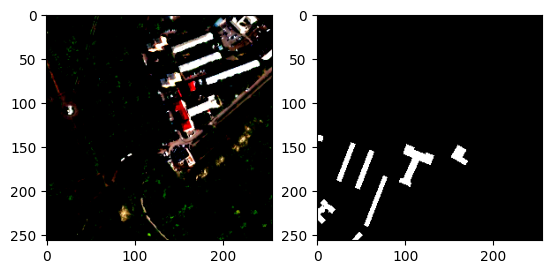

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


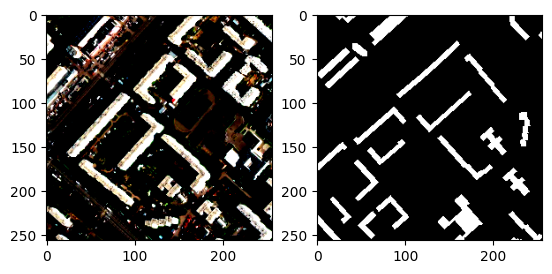

/home/werserk/PycharmProjects/skoltech-Infrastructure/venv/lib/python3.11/site-packages/albumentations/augmentations/functional.py:825: RuntimeWarning: invalid value encountered in power
  img = np.power(img, gamma)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/werserk/PycharmProjects/skoltech-Infrastructure/venv/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


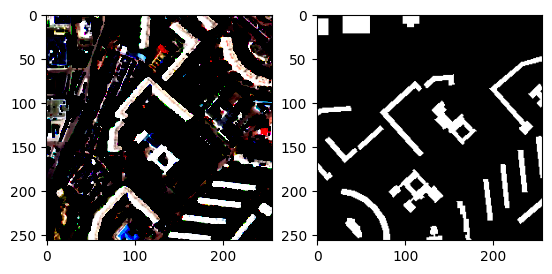

In [8]:
import matplotlib.pyplot as plt

k = 0
for image, mask in train_dataset:
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(CHW2HWC(image).numpy())
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.show()

    k += 1
    if k == 3:
        break

In [9]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True
)

In [35]:
from torchgeo.models import ResNet50_Weights
import segmentation_models_pytorch as smp

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
weights = ResNet50_Weights.SENTINEL2_RGB_MOCO
model = smp.Unet(encoder_name="resnet50", encoder_weights=None,
                 in_channels=weights.meta["in_chans"], classes=1)
model.encoder.load_state_dict(weights.get_state_dict(), strict=False)
model.to(device)

cuda


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [36]:
class IoULoss(torch.nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        intersection = torch.sum(y_pred * y_true)
        union = torch.sum(y_pred) + torch.sum(y_true)
        print(y_pred)
        iou = (intersection + self.eps) / (union - intersection + self.eps)
        print(y_pred.shape, y_true.shape, iou)
        return 1 - iou


class DiceMetric:
    def __init__(self, eps=1e-7):
        self.eps = eps

    def __call__(self, y_pred, y_true):
        intersection = torch.sum(y_pred * y_true)
        union = torch.sum(y_pred) + torch.sum(y_true)
        dice = (2 * intersection + self.eps) / (union + self.eps)
        return dice

In [37]:
criterion = IoULoss()
metric = DiceMetric()

In [38]:
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR

epochs = 10
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=1e-4, epochs=epochs,
                       steps_per_epoch=len(train_loader))

In [39]:
from src.modelling.train import fit_loop

fit_loop(model,
         train_loader,
         val_loader,
         optimizer,
         scheduler,
         criterion,
         metric,
         epochs,
         device)

  0%|          | 0/158 [00:00<?, ?it/s]

/home/werserk/PycharmProjects/skoltech-Infrastructure/venv/lib/python3.11/site-packages/albumentations/augmentations/functional.py:825: RuntimeWarning: invalid value encountered in power
  img = np.power(img, gamma)


tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        ...,


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, 

KeyboardInterrupt: 